This notebook will quantify how accurately different parameters of a CF-FM call can be measured by the ```measure_horseshoe_bat_calls``` package. 

This is the second round of tests where I've made significant changes to the package. 

-- 2020-04-18


### Stress-testing the package: how accurate is it really?

With the ```simulate_calls```  module of the package, there's a lot of flexibility in what kinds of calls can be simulated. Here let's run through a range of:

* Call durations
* CF properties : peak frequency, duration
* FM properties : terminal frequency (bandwidth), duration

We will *not* be testing more basic parameters such as rms or energy because it is assumed that if the call parts are segmented correctly, the rest of the parameters will be matched correctly too. 

In [1]:
%matplotlib notebook

In [2]:
from IPython.display import Audio

In [3]:
import numpy as np 
import pandas as pd
import scipy.signal as signal
from tqdm import trange, tqdm
import measure_horseshoe_bat_calls 
from measure_horseshoe_bat_calls.view_horseshoebat_call import *
from measure_horseshoe_bat_calls.segment_horseshoebat_call import *
from measure_horseshoe_bat_calls.simulate_calls import make_cffm_call, make_fm_chirp, silence, make_tone
from measure_horseshoe_bat_calls.signal_processing import get_peak_frequency, get_frequency_resolution
import measure_horseshoe_bat_calls.user_interface as ui

In [4]:
# Note the version of the package being run
measure_horseshoe_bat_calls.__version__

'1.9.9'

### An synthetic call example: 
Synthetic calls are the way to go in testing the accuracy of the package because we do not know *a priori* what the vocalisations of an animal call will be like, or what it should be like. Thus, the only way to convincingly test the performance of a tool like this is through simulation. 

In [5]:
call_parameters = {'cf':(100000, 0.01),
                    'upfm':(80000, 0.002),
                    'downfm':(60000, 0.003),
                    }

fs = 250*10**3 # 500kHz sampling rate
synthetic_call, freq_profile = make_cffm_call(call_parameters, fs)

# plot
wavef, spec = visualise_call(synthetic_call, fs, fft_size=512)
spec.set_ylim(0,125000)

<IPython.core.display.Javascript object>

(0, 125000)

### Test parameter space :

Let us now test the performance of the package with audio clips containing only a single call, with no noise or any silent background. This test run will quantify the call-part segmentation (CF-FM).

In [6]:
cf_durations = [0.005, 0.010, 0.015]
cf_peakfreq = [40000]#, 60000, 90000]
fm_durations = [0.001] # 0.001, 0.002,
fm_bw = [5000]#10000, 20000]

In [7]:
all_combinations = np.array(np.meshgrid(cf_peakfreq, cf_durations,
                                        fm_bw,fm_durations,
                                        np.flip(fm_bw),np.flip(fm_durations)))
all_params = all_combinations.flatten().reshape(6,-1).T

col_names = ['cf_peak_frequency', 'cf_duration',
             'upfm_bw', 'upfm_duration',
             'downfm_bw', 'downfm_duration']

parameter_space = pd.DataFrame(all_params, columns=col_names)
parameter_space['upfm_terminal_frequency'] = parameter_space['cf_peak_frequency'] - parameter_space['upfm_bw']
parameter_space['downfm_terminal_frequency'] = parameter_space['cf_peak_frequency'] - parameter_space['downfm_bw']

In [8]:
parameter_space

,cf_peak_frequency,cf_duration,upfm_bw,upfm_duration,downfm_bw,downfm_duration,upfm_terminal_frequency,downfm_terminal_frequency
0,40000.0,0.005,5000.0,0.001,5000.0,0.001,35000.0,35000.0
1,40000.0,0.010,5000.0,0.001,5000.0,0.001,35000.0,35000.0
2,40000.0,0.015,5000.0,0.001,5000.0,0.001,35000.0,35000.0


In [9]:
parameter_columns = ['cf_peak_frequency', 'cf_duration',
                     'upfm_terminal_frequency', 'upfm_duration',
                     'downfm_terminal_frequency', 'downfm_duration']

In [10]:
all_calls = {}
for row_number, parameters in tqdm(parameter_space.iterrows(),
                                   total=parameter_space.shape[0]):

    cf_peak, cf_durn, upfm_terminal, upfm_durn, downfm_terminal, downfm_durn = parameters[parameter_columns]
    call_parameters = {'cf':(cf_peak, cf_durn),
                        'upfm':(upfm_terminal, upfm_durn),
                        'downfm':(downfm_terminal, downfm_durn),
                        }

    fs = 500*10**3 # 500kHz sampling rate
    synthetic_call, _ = make_cffm_call(call_parameters, fs)
    synthetic_call *= signal.tukey(synthetic_call.size, 0.01)
    all_calls[row_number] = synthetic_call


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 192.31it/s]


In [11]:
parameter_space.shape

(3, 8)

In [12]:
freq_resolution_columns = ['cf_peakfreq_resolution', 'downfm_terminalfreq_resolution',
                          'upfm_terminalfreq_resolution']

In [13]:
accuracy = parameter_space.copy()

In [14]:
all_measures = []
seg_outputs = {}
for call_number in trange(parameter_space.shape[0]):
    output = ui.segment_and_measure_call(all_calls[call_number], fs,
                                         segment_method='pwvd',
                                          fmrate_threshold=0.5
                                        )
    seg_output, call_parts, measurements, backg_output = output
    measurements['call_number'] = call_number
    all_measures.append(measurements)
    seg_outputs[call_number] = seg_output[-1]
    #this_call_msmts = pd.DataFrame(measurements, index=[call_number])
    #measurement_accuracy =  this_call_msmts.loc[call_number,parameter_columns]/parameter_space.loc[call_number,parameter_columns]
    #accuracy.loc[call_number,parameter_columns] = measurement_accuracy


  0%|                                                    | 0/3 [00:02<?, ?it/s]


NameError: name 'noise_supp_fp' is not defined

In [ ]:
final_measurement_set = pd.concat(all_measures).reset_index(drop=True)

In [ ]:
final_measurement_set

In [ ]:
d = seg_output[-1]

In [ ]:
d.keys()

<IPython.core.display.Javascript object>


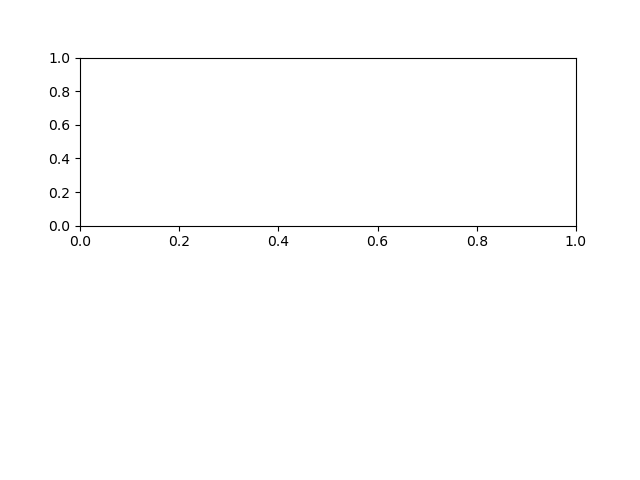

NameError: name 'd' is not defined

In [18]:
plt.figure()
a = plt.subplot(211)
make_waveform(d['raw_frequency_profile'],fs)
make_waveform(d['cleaned_fp'],fs)
make_waveform(d['fitted_fp'],fs)
plt.plot()
plt.subplot(212, sharex=a)
make_waveform(d['fmrate'], fs)

In [15]:
call_props = {'cf':(9000, 0.010),
             'upfm':(3000, 0.001),
             'downfm':(2000,0.003)}
# downfm has a fmrate of 15kHz/ms
# upfm has an fmrate of 10kHz/ms
fs = 44100
synth_call, freq_profile = make_cffm_call(call_props, fs)

In [16]:
Audio(synth_call, rate=fs)

In [17]:
output = ui.segment_and_measure_call(synth_call, fs,
                                         segment_method='pwvd',
                                          fmrate_threshold=0.05,
                                         sample_every=0.1*10**-3
                                        )
seg_output, call_parts, measurements, backg_output = output

NameError: name 'noise_supp_fp' is not defined

In [ ]:
measurements

In [19]:
noisy_synth_call = synth_call + np.random.normal(0,10**-(20/20.0),synth_call.size)
noisy_synth_call /= np.max(np.abs(noisy_synth_call))

# add a sweep just for fun
sweep = make_fm_chirp(100, 5000, 0.005, fs)

noisy_w_sweep = np.concatenate((synth_call, silence(0.002,fs),
                                sweep))
noisy_w_sweep += np.random.normal(0,10**(-20/20),noisy_w_sweep.size)
noisy_w_sweep /= np.max(np.abs(noisy_w_sweep))

<IPython.core.display.Javascript object>


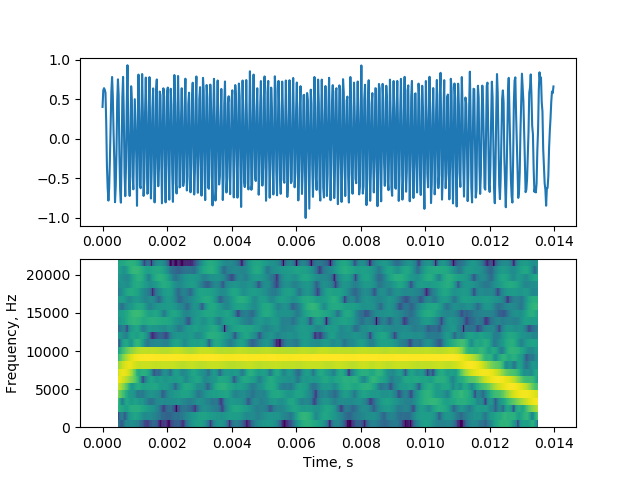

(<matplotlib.axes._subplots.AxesSubplot at 0x14712648>,
 <matplotlib.axes._subplots.AxesSubplot at 0x14db3f08>)

In [20]:
visualise_call(noisy_synth_call, fs)

In [ ]:
output = ui.segment_and_measure_call(noisy_synth_call, fs,
                                         segment_method='pwvd',
                                          fmrate_threshold=0.5,
                                         sample_every=0.1*10**-3,
                                         percentile=99.9
                                        )
seg_output, call_parts, measurements, backg_output = output

In [ ]:
measurements

In [ ]:
0.84*0.96*0.97

In [ ]:
0.001/0.001179

In [ ]:
plt.figure()
plt.plot(seg_output[-1]['fmrate'])

In [ ]:
w,s = visualise_call(noisy_w_sweep, fs)
w.hlines(10**(-9/20.0),0,noisy_w_sweep.size/fs, zorder=4)

In [ ]:
output = ui.segment_and_measure_call(noisy_w_sweep, fs,
                                         segment_method='pwvd',
                                          fmrate_threshold=0.5,
                                         sample_every=0.1*10**-3,
                                         background_noise=-6.5
                                        )
seg_output, call_parts, measurements, backg_output = output
measurements

In [ ]:
output = ui.segment_and_measure_call(noisy_w_sweep, fs,
                                         segment_method='peak_percentage',
                                          peak_percentage=0.999,
                                         background_noise=-9,
                                         window_size=250
                                        )
seg_output, call_parts, measurements, backg_output = output
measurements

### What about weird bird type sounds: 
Here, let's make a bird-type call, with an upFM, Cf, upfm and then a final CF

In [ ]:
help(make_fm_chirp)

In [21]:
fs = 22100
song_gap = silence(0.005,fs)
all_call_parts = [
                  make_fm_chirp(100,5000,0.010,fs),
                  song_gap,
                  make_tone(5000,0.01,fs),
                  song_gap,
                  make_fm_chirp(5000,7000,0.01,fs),
                 song_gap,
                  make_tone(8000,0.01,fs)]
fake_bird_song = np.concatenate(all_call_parts)

In [52]:
song_gap.size

110

In [22]:
4900/10

490.0

In [23]:
Audio(fake_bird_song, rate=fs)

<IPython.core.display.Javascript object>


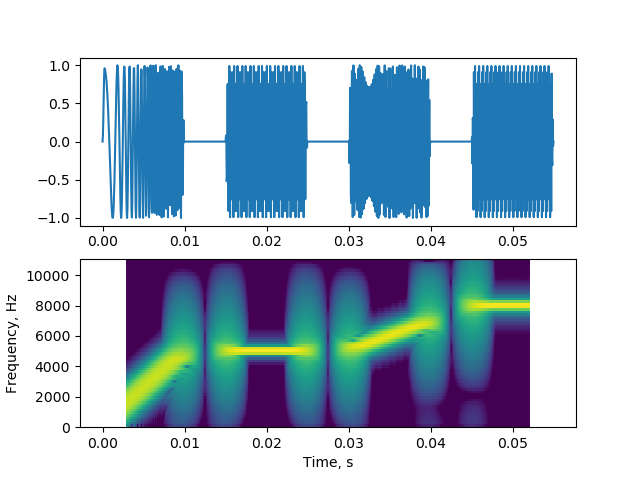

(<matplotlib.axes._subplots.AxesSubplot at 0x150b2c48>,
 <matplotlib.axes._subplots.AxesSubplot at 0x150ec648>)

In [24]:
visualise_call(fake_bird_song, fs, fft_size=128)

In [25]:
from measure_horseshoe_bat_calls.frequency_tracking import generate_pwvd_frequency_profile as gpwvd
from measure_horseshoe_bat_calls.frequency_tracking import find_above_noise_regions
from measure_horseshoe_bat_calls.signal_cleaning import smooth_over_potholes

In [26]:
freqs, _ = gpwvd(fake_bird_song, fs)

In [27]:
regions = find_above_noise_regions(fake_bird_song, fs, background_noise=-10, window_size=10)

c:\users\tbeleyur\google drive\holger goerlitz- imprs\phd_2015\projects and analyses\packages\measure_horseshoe_bat_calls\measure_horseshoe_bat_calls\signal_processing.py:13: RuntimeWarning: divide by zero encountered in log10
  return 20*np.log10(X)


<IPython.core.display.Javascript object>


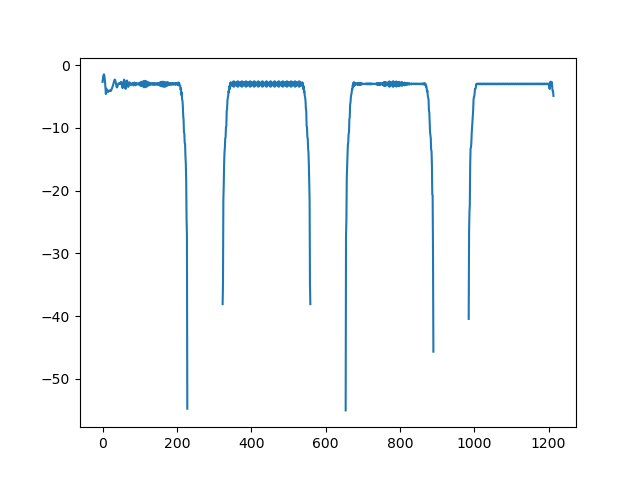

In [28]:
plt.figure()
plt.plot(dB(moving_rms_edge_robust(fake_bird_song, window_size=10)))

In [29]:
from scipy.ndimage import filters

In [30]:
freqs_by_region = [freqs[each] for each in regions]


freq_segment = freqs_by_region[3]
v_freq = np.abs(np.gradient(freq_segment))/(1/fs)
v_freq *= 10**-6

#v_freq = filters.percentile_filter(v_freq, 50, int(fs*0.5*10**-3))

ac_freq = np.abs(np.gradient(v_freq))

#ac_freq = filters.percentile_filter(ac_freq, 50, 11)
impulse = np.abs(np.gradient(ac_freq))/(1/fs)


<IPython.core.display.Javascript object>


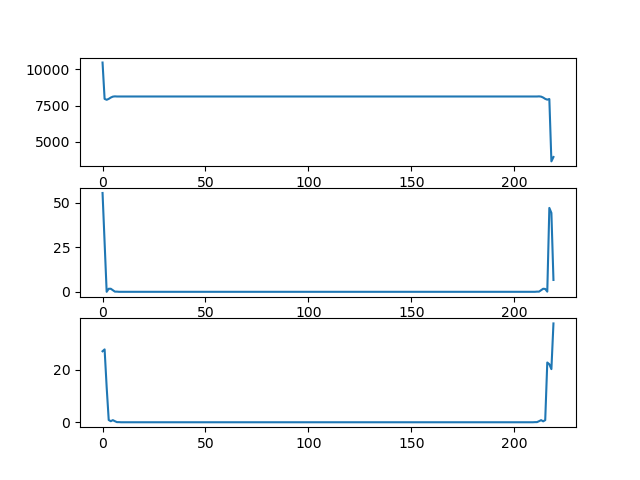

In [31]:
plt.figure()
a = plt.subplot(311)
plt.plot(freq_segment)
plt.subplot(312,sharex=a)
plt.plot(v_freq)
plt.subplot(313, sharex=a)
plt.plot(ac_freq)

In [45]:
def reflect_and_pwvd(input_signal, fs,reflect_window=10**-3):
    
    reflect_samples = int(fs*reflect_window)
    left_edge = input_signal[:reflect_samples][::-1]
    right_edge = input_signal[-reflect_samples:][::-1]
    edge_reflected = np.concatenate((left_edge,input_signal,right_edge))
    freqs, _ = gpwvd(edge_reflected, fs)
    return freqs[reflect_samples:-reflect_samples]

In [59]:
part_song = fake_bird_song[regions[2]]
freqs  =  reflect_and_pwvd(part_song,fs)
norm_freq,_ = gpwvd(part_song,fs)

<IPython.core.display.Javascript object>


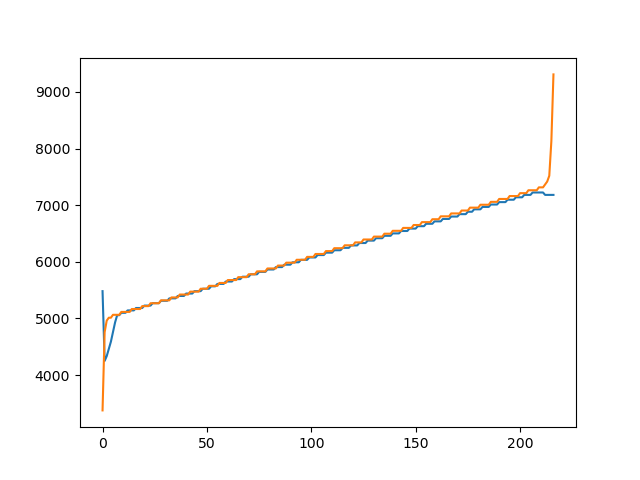

In [60]:
plt.figure()
plt.plot(freqs)
plt.plot(norm_freq)

In [ ]:
output = ui.segment_and_measure_call(fake_bird_song, fs,
                                         segment_method='pwvd',
                                          fmrate_threshold=1,
                                         background_noise=-90
                                        )
seg_output, call_parts, measurements, backg_output = output
measurements

In [ ]:
seg_output[-1].keys()

In [ ]:
plt.figure()
a = plt.subplot(211)
plt.plot(seg_output[-1]['raw_frequency_profile'])
plt.plot(seg_output[-1]['cleaned_fp'])
plt.plot(seg_output[-1]['fitted_fp'])
plt.subplot(212)
plt.plot(seg_output[-1]['fmrate'])

In [ ]:
from measure_horseshoe_bat_calls.frequency_tracking import generate_pwvd_frequency_profile

In [ ]:
raw_freq_profile, frequency_index = generate_pwvd_frequency_profile(full_call, fs)
noise_suppressed_freq_profile = suppress_background_noise(raw_freq_profile,
                                                          full_call, 
                                                          background_noise=-10,
                                                             window_size=25)

In [ ]:
above_nois = find_above_noise_regions(full_call, fs, background_noise=-10, window_size=20)

In [ ]:
for each in above_nois:
    

In [ ]:
plt.figure()
plt.plot()

In [ ]:
t= np.linspace(0,0.01,int(fs*0.01))
nonwindow_chirp = signal.chirp(t, 100, t[-1],5000)
onems = int(0.001*fs)

padded_nonwindow_chirp = np.concatenate((np.zeros(onems),
                                         nonwindow_chirp,
                                         np.zeros(onems)))

In [ ]:
fp_nonpadded, _ = generate_pwvd_frequency_profile(nonwindow_chirp, fs)
fp_padded, _ = generate_pwvd_frequency_profile(padded_nonwindow_chirp, fs)

In [ ]:
plt.figure()
plt.plot(fp_padded)
plt.vlines([onems, fp_padded.size-onems],100,5000)

In [ ]:
5.0//2

In [ ]:
dbrms = dB(moving_rms_edge_robust(full_call, window_size=25))

In [ ]:
plt.figure()
plt.plot(raw_freq_profile)
plt.plot(noise_suppressed_freq_profile)

In [ ]:
plt.figure()
plt.plot(info['fmrate'])

In [ ]:
plt.figure()
plt.plot(cf)
plt.plot(fm)

### What about experimental sounds with harmonics?

In [ ]:
import measure_horseshoe_bat_calls.data as data

In [ ]:
all_calls = data.example_calls

In [ ]:
eg_call, fs = all_calls[0]
b,a = signal.butter(2, np.array([30000, 110000])/fs,'bandpass')
eg_call = signal.filtfilt(b,a, eg_call)

In [ ]:
w,s = visualise_call(eg_call, fs, fft_size=int(fs*0.002))
w.hlines(10**(-44/20.0),0,0.014)

In [ ]:
output = ui.segment_and_measure_call(eg_call, fs,
                                         segment_method='pwvd',
                                          fmrate_threshold=0.5,
                                         sample_every=0.1*10**-3,
                                         background_noise=-56
                                        )
seg_output, call_parts, measurements, backg_output = output
measurements

In [ ]:
plt.figure()
d = seg_output[-1]
plt.plot(d['fmrate'])

In [ ]:
w,s = visualise_call(eg_call, fs, fft_size=int(fs*0.002))
s.plot( make_x_time(d['cleaned_fp'],fs), d['fitted_fp'])